In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from scipy.stats import entropy
from numpy.linalg import norm


In [2]:
import ot
from utils import simulate_dataset, format_dataset, simulate_dataset_UF
from repairs import DI_list_geometric_repair, DI_list_random_repair,DI_list_merge_repair
from sklearn.manifold import TSNE
from disparate import *

In [3]:

blue1 = '#1f77b4' # darker blue
blue2 = '#aec7e8' # lighter blue

# Two shades of red
red1 = '#d62728' # darker red
red2 = '#ff9896' # lighter red

light_green = '#90EE90'
dark_green = '#006400'


In [4]:
def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X= gmm_p.score_samples(X)
    log_q_X= gmm_q.score_samples(X)
    return log_p_X.mean() - log_q_X.mean()

In [5]:

import numpy as np
from scipy.spatial.distance import cdist

def find_closest_pair(means, covariances):
    # Compute the distance matrix between all pairs of Gaussians
    dist_matrix = cdist(means, means, metric='mahalanobis', VI=covariances)

    # Set the diagonal elements to infinity, so that each Gaussian is not the closest to itself
    np.fill_diagonal(dist_matrix, np.inf)

    # Initialize the two closest pairs with the first pair of indices
    pair1, pair2 = [0, 1], [2, 3]
    
    # Initialize the closest distance with the distance between the first pair of Gaussians
    closest_dist = dist_matrix[pair1[0], pair1[1]] + dist_matrix[pair2[0], pair2[1]]
    
    # Loop through all pairs of Gaussians to find the two closest pairs
    for i in range(len(means)):
        for j in range(i+1, len(means)):
            for k in range(len(means)):
                for l in range(k+1, len(means)):
                    # Check if the two pairs share any elements
                    if i not in [k, l] and j not in [k, l]:
                        # Compute the distance between the two pairs of Gaussians
                        dist = dist_matrix[i, j] + dist_matrix[k, l]
                        # If the distance is smaller than the current closest distance, update the closest pairs
                        if dist < closest_dist:
                            closest_dist = dist
                            pair1, pair2 = [i, j], [k, l]
    
    # Return the two closest pairs
    return pair1, pair2


In [6]:
def merge(mu, mu2, cov , cov2, weights):
    # merge two Gaussian
    # Input:
    # mu, mu2: means of the two Gaussians
    # cov, cov2: covariance matrices of the two Gaussians
    # weights: weights of the two Gaussians
    # Output:
    # mu_m: mean of the merged Gaussian
    # cov_m: covariance matrix of the merged Gaussian
    # weight_m: weight of the merged Gaussian
    # Reference: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Merging_of_normal_distributions
    # Written by Mo Chen (

    alpha = (weights[0])**2/(weights[0]+weights[1])**2
    #alpha = (weights[0])/(weights[0]+weights[1])

    mu_m = (weights[0]*mu + weights[1]*mu2)/(weights[0]+weights[1])
    #cov_m = (weights[0]*cov + weights[1]*cov2 + weights[0]*weights[1]/(weights[0]+weights[1])*(mu-mu2).dot((mu-mu2).T))/(weights[0]+weights[1])
    cov_m  = alpha*cov + (1-alpha)*cov2
    weight_m = weights[0]+weights[1]

    return mu_m, cov_m, weight_m

In [7]:
def sample_guassian_UF(mu, mu2, mu3, mu4, cov, cov2, cov3, cov4, n, prob, d):
    # Compute the Decomposition:
    A = np.linalg.cholesky(cov)
    A2 = np.linalg.cholesky(cov2)
    A3 = np.linalg.cholesky(cov3)
    A4 = np.linalg.cholesky(cov4)

    X = np.zeros((d+2,n))
    
    for i in range(n):
        r = np.random.rand() 
        if r <= prob[0]:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A,Z) + + np.reshape(mu, (2,1))
     
            #replace the i-th row of X with x
            X[0,i] = x[0]
            X[1,i] = x[1]
            #mixing label
            X[2,i] = 0
            #protected label
            X[3,i] = 0
 
            #add a 0 to the end of each sample
        elif  prob[0] <= r <= prob[0] + prob[1]:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A2,Z) + + np.reshape(mu2, (2,1))
        
            X[0,i] = x[0]
            X[1,i] = x[1]
            X[2,i] = 0
            #protected label
            X[3,i] = 1

        elif  prob[0] + prob[1] <= r <= prob[0] + prob[1] + prob[2]:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A3,Z) + + np.reshape(mu3, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            #true label
            X[2,i] = 1
            #protected label
            X[3,i] = 0
        else:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A4,Z) + + np.reshape(mu4, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            #true label
            X[2,i] = 1
            #protected label
            X[3,i] = 1
        
    return X

In [8]:
def sample_guassian_F(mu, mu2, mu3, mu4, cov, cov2, cov3, cov4, n, prob, d): 

    means = np.array([mu,mu2, mu3, mu4])
    # print('means',means)
    covariances = np.array([cov, cov2, cov3, cov4])
    weights = np.array([prob[0], prob[1], prob[2], prob[3]])

    #first find closest pairs using malanobis distance
    closest_pairs = find_closest_pair(means, covariances)
    # print ('closest pairs ' , closest_pairs)
    # print('closest pair 1 ' , means[closest_pairs[0][0]], means[closest_pairs[0][1]])
    # print('closest pair 2 ' , means[closest_pairs[1][0]], means[closest_pairs[1][1]])

    print(weights[closest_pairs[0]])
    


    #then merge the two closest pairs using the merge function
    # mu_m, cov_m, weight_m = merge(means[closest_pairs[0][0]], means[closest_pairs[0][1]], covariances[closest_pairs[0][0]], covariances[closest_pairs[0][1]], weights[closest_pairs[0]])
    # mu_m2, cov_m2, weight_m2 = merge(means[closest_pairs[1][0]], means[closest_pairs[1][1]], covariances[closest_pairs[1][0]], covariances[closest_pairs[1][1]], weights[closest_pairs[1]])
    mu_m, cov_m, weight_m = merge(means[closest_pairs[0][0]], means[closest_pairs[0][1]], covariances[closest_pairs[0][0]], covariances[closest_pairs[0][1]], weights[closest_pairs[0]])
    mu_m2, cov_m2, weight_m2 = merge(means[closest_pairs[1][0]], means[closest_pairs[1][1]], covariances[closest_pairs[1][1]], covariances[closest_pairs[1][0]], weights[closest_pairs[1]])

  
    #now sample from the new mixture

    # Compute the Decomposition:
    A = np.linalg.cholesky(cov_m)
    A2 = np.linalg.cholesky(cov_m2)

    X = np.zeros((d+1,n))

    for i in range(n):
        r = np.random.rand() 
        if r <= weight_m:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A,Z) + + np.reshape(mu_m, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            X[2,i] = 0 
        else:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A2,Z) + + np.reshape(mu_m2, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            X[2,i] = 1
    return X

    # return X  

In [9]:
def TM_UF(y_log, y_test):
    T = np.zeros((len(np.unique(y_log)), len(np.unique(y_test))))
    for i in range(0,4):
        for j in range(0,2):
            T[j,i] = np.sum((y_log == j) & (y_test == i))

    # print (T)

    for i in range(0,4):
        T[:,i] = T[:,i]/np.sum(T[:,i])
    # print ('unfair T')
    # print (T)

    

    return T

In [10]:
def TM_F(y_log, y_test):
    T = np.zeros((len(np.unique(y_log)), len(np.unique(y_test))))
    for i in range(0,2):
        for j in range(0,2):
            T[j,i] = np.sum((y_log == j) & (y_test== i))


    #normalize the rows
    for i in range(0,2):
        T[:,i] = T[:,i]/np.sum(T[:,i])
        

    m = [[1,1,0,0], [0,0,1,1]]
    m = np.array(m)

    T = np.dot( T,m)
   


   
    # print ('fair T')
    # print (T)


    return T

In [11]:
def classfiy(data, label):

    X_train, X_test, y_train, y_test = train_test_split(data.T, label, test_size=0.2, random_state=0)
    X_train = X_train[:,0:2]
    X_label_t = X_train[:,0:2]

  

    X_test_label = X_test[:,2]
    X_test = X_test[:,0:2]



    #cluster with GMM
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
    gmm.fit(X_train)
    y_gmm = gmm.predict(X_test)

    JS1 = accuracy_score(y_test, y_gmm)
    ARI_1 = adjusted_rand_score(y_test, y_gmm)

    # label flip
    y_gmm_flip = 1 - y_gmm

    JS2 = accuracy_score(y_test, y_gmm_flip)

    #distance 
    dist1 = (JS1 -ARI_1)**2
    dist2 = (JS2 - ARI_1)**2

    if dist2 < dist1:
        y_gmm = y_gmm_flip
        

    return y_gmm, y_test, X_test, X_test_label

In [12]:
def f_cov(var_x, var_y, corr): 
    return np.matrix([[var_x, corr * np.sqrt(var_x * var_y)], [corr * np.sqrt(var_x * var_y), var_y]])

In [13]:
def plot_fair_vs_unfair(X_UF, y_Ap, y_Au,  X_F, y_F): 
    
    blue1 = '#1f77b4' # darker blue
    blue2 = '#aec7e8' # lighter blue

    # Two shades of red
    dark_red = '#d62728' # darker red
    light_red = '#ff9896' # lighter red

    light_green = '#90EE90'
    dark_green = '#006400'


    

    #plot the results
    
    plt.subplot(1, 2, 1)
    plt.scatter(X_UF[0, (y_Au == 0) & (y_Ap == 0)], X_UF[1, (y_Au == 0) & (y_Ap == 0)],  c= light_red, label=r'($A_u$, $A_p$) = (0,0)', alpha=0.7)
    plt.scatter(X_UF[0, (y_Au == 0) & (y_Ap == 1)], X_UF[1, (y_Au == 0) & (y_Ap == 1)],  c= dark_red , label=r'($A_u$, $A_p$) = (0,1)',alpha=0.7)
    plt.scatter(X_UF[0, (y_Au == 1) & (y_Ap == 0)], X_UF[1, (y_Au == 1) & (y_Ap == 0)],  c= light_green , label=r'($A_u$, $A_p$) = (1,0)',alpha=0.7)
    plt.scatter(X_UF[0, (y_Au == 1) & (y_Ap == 1)], X_UF[1, (y_Au == 1) & (y_Ap == 1)],  c=  dark_green , label=r'($A_u$, $A_p$) = (1,1)',alpha=0.7)
  
    plt.ylabel('x2',fontsize=15)
    plt.xlabel('x1',fontsize=15)
    # plt.xlim(-4, 8)
    # plt.ylim(-4, 8)

    plt.legend( fontsize=15)



    plt.title('Unfair Mixture Sampling: '  ,fontsize=15)
    plt.subplot(1, 2, 2)
    plt.scatter(X_F[0, y_F == 0], X_F[1, y_F == 0], c= 'red', label=r'($A_u$) = (0)',alpha=0.7)
    plt.scatter(X_F[0, y_F == 1], X_F[1, y_F == 1], c= 'green', label=r'($A_u$) = (1)',alpha=0.7)
    # plt.scatter(X_F[0, y_F == 2], X_F[1, y_F == 2], c= red1, label=r'($A_u$, $A_p$) = (1,0)')
    # plt.scatter(X_F[0, y_F == 3], X_F[1, y_F == 3], c= red2, label=r'($A_u$, $A_p$) = (1,1)')
    plt.ylabel('x2',fontsize=15)
    plt.xlabel('x1',fontsize=15)
    plt.legend( fontsize=15)
    plt.title('Fair Mixture Sampling: ',fontsize=15)
    # plt.xlim(-4, 8)
    # plt.ylim(-4, 8)
    plt.show()


In [14]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [15]:
def KLD(P, Q, epsilon): 
    # a small positive constant
    _P = (P + epsilon) / np.linalg.norm(P + epsilon, ord=1) 
    _Q = (Q + epsilon) / np.linalg.norm(Q + epsilon, ord=1) 
    return entropy(_P, _Q)

[0.25 0.25]


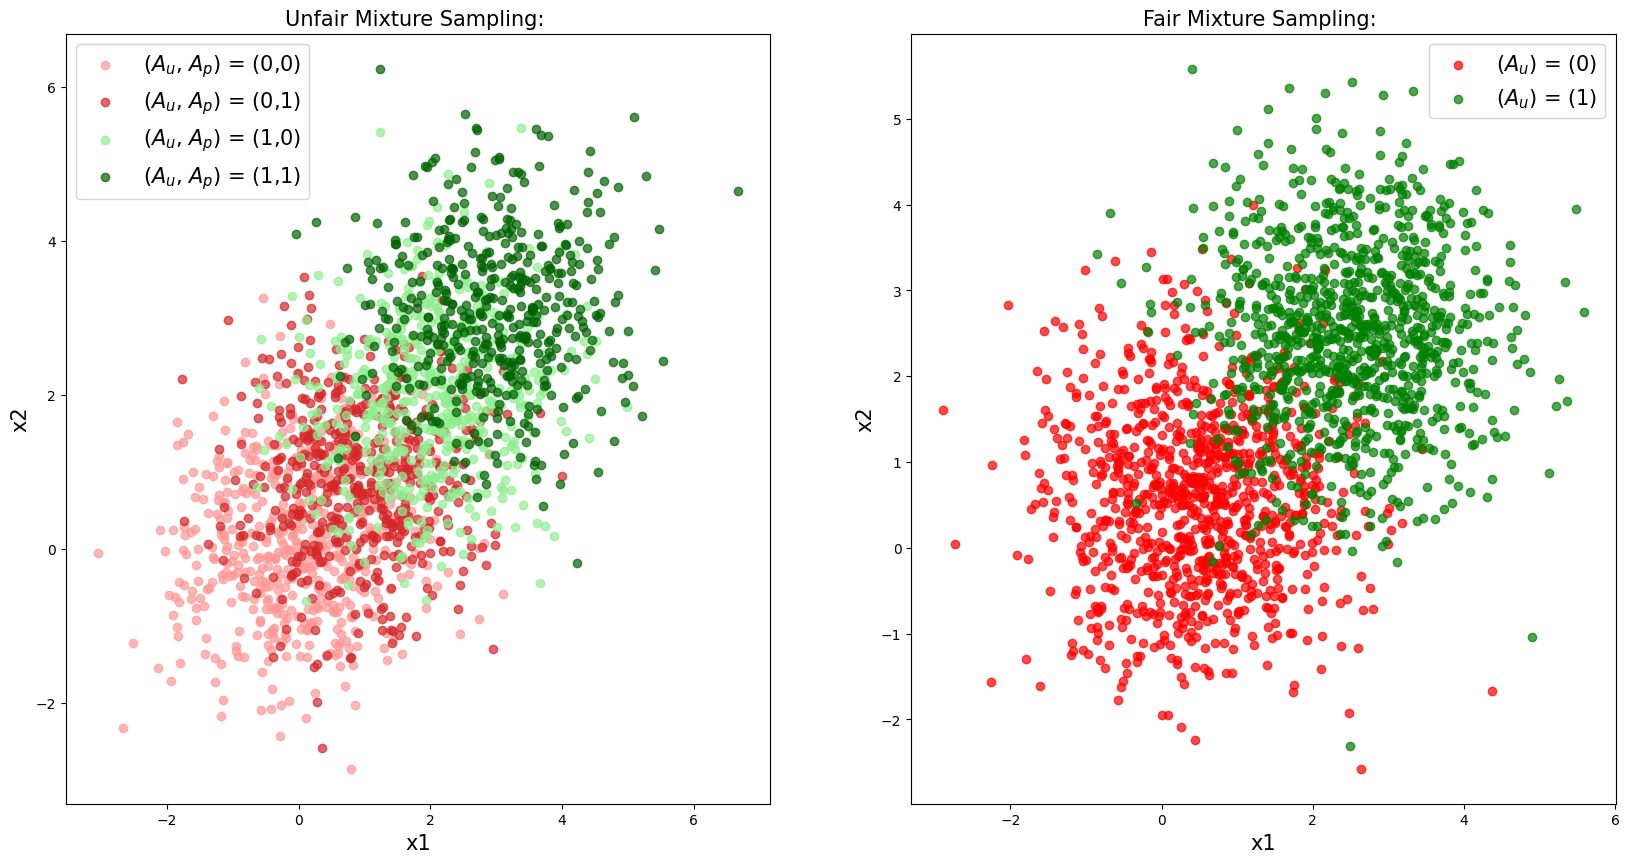

In [16]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score

mu  = [0, 0]
mu2 = [1, 1]
mu3 = [2,2]
mu4 = [3,3]

cov  = [[1, 0], 
        [0, 1]]
cov2 = [[1, 0], 
        [0, 1]]
cov3 = [[1, 0], 
        [0, 1]]
cov4  = [[1, 0], 
        [0, 1]]



#Pr[Ap ] = 0.6
prob_p = [0.5, 0.5]
#Pr[Au | Ap=0 ]
p_u1  = [ 0.5, 0.5]
#Pr[Au | Ap=1 ]
p_u2  = [ 0.5, 0.5]

prob = [p_u1[0]*prob_p[0], p_u1[1]*prob_p[0], p_u2[0]*prob_p[1], p_u2[1]*prob_p[1]]
n = 2000
d = 2




X_UF = sample_guassian_UF(mu, mu2, mu3, mu4, cov, cov2, cov3, cov4, n, prob, d)
y_Ap = X_UF[3,:]
y_Au = X_UF[2,:]


#sample from the fair mixture
X_F = sample_guassian_F(mu, mu2, mu3, mu4, cov, cov2, cov3, cov4, n, prob, d)
y_F = X_F[2,:]

fig = plt.figure(figsize=(20, 10))
plot_fair_vs_unfair(X_UF, y_Ap, y_Au,  X_F, y_F)
plt.show()

#fair clustering





In [17]:
def KLD_L(Ms, N, prob):

    prob1 = np.array(prob)
    epsilon = 1e-10
    #check for flip
    M = Ms[0]
    M_p = M*prob1.T
    N_p = N*prob1.T
    N_flp = np.flipud(N_p)
    #kld from m to n then from m to n flipped
    kld1 = np.sum(KLD(M_p, N_p, epsilon))
    kld2 = np.sum(KLD(M_p, N_flp, epsilon))

    if kld1 > kld2:
        N_p = N_flp

    print (N_p)
    print('---')
    print (N_flp)


    

   

    KLD_list = []
    for i in range(len(Ms)):
        
        M = Ms[i]
        M_p = M*prob1.T

        #kld between M and N 
        klds = []
        epsilon = 1e-10

        # print (M_p)
        kld = KLD(M_p, N_p, epsilon)
        kld = np.sum(kld)
        KLD_list.append(kld)


    return KLD_list

In [18]:
def unfair_clustering(X_UF, y_Ap, y_Au ):
    X_UF = X_UF[0:2,:]
    #learn 4 components
    gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0).fit(X_UF.T)
    return gmm

In [19]:
from repairs_v2 import DI_list_geometric_repair, DI_list_merge_repair, DI_list_random_repair


X_F = sample_guassian_F(mu, mu2, mu3, mu4, cov, cov2, cov3, cov4, n, prob, d)
y_A = X_F[2,:]

X_UF = sample_guassian_UF(mu, mu2, mu3, mu4, cov, cov2, cov3, cov4, n, prob, d)
y_Ap= X_UF[3,:]
y_Au = X_UF[2,:]


#fair clustering

X0 = X_UF[:,y_Ap==0]
X1 = X_UF[:,y_Ap==1]


Y0= X0[2:4,:].T
Y1= X1[2:4,:].T

X0 = X0[0:2,:].T
X1 = X1[0:2,:].T
iter = 10
# N, labels_gmm, y_test = fair_clustering(X_F.T, y_A)

gmm_unfair = unfair_clustering(X_UF, y_Ap, y_Au)
DIs, X0r, X1r, KLD_geo, kld_gmm_geo = DI_list_geometric_repair(X0, X1,iter, Y0, Y1, gmm_unfair)


DIs_2, X0r, X1r, KLD_merge ,kld_gmm_merge = DI_list_merge_repair(X0, X1,iter, Y0, Y1, gmm_unfair )

DI_3, X0r, X1r, KLD_random, kld_gmm_random = DI_list_random_repair(X0, X1,iter, Y0, Y1, gmm_unfair )

# alpha_range = np.linspace(0,1,iter)


# print('DI:', DIs_2)


# #plot the DI
# # fig = plt.figure(figsize=(10, 8))
# # plt.plot(alpha_range, DIs, linestyle='dashed', label = 'OT :Geometric')
# # plt.plot(alpha_range, DIs_2,  label = 'merge')
# # plt.plot(alpha_range, DI_3, linestyle='dashed', label = 'OT: Random')

# # plt.ylabel('DI')
# # plt.xlabel('Amount of repair\n'+r'$\lambda$')
# # plt.ylabel('Disparate Impact')
# # plt.legend()
# # # generate a sequence of 5 evenly spaced numbers between 0 and 4
# # grid_pos = np.arange(0, 1.05, 0.05)

# # # draw vertical grid lines at the specified positions
# # plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
# # plt.gca().set_xticks(grid_pos, minor=False)
# # plt.show()






[0.25 0.25]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [59]:
from scipy.stats import chi2
def fair_clustering(X_F,y_A ):
    
    X_F  = X_F[:,0:2]
    X_train, X_test, y_train, y_test = train_test_split(X_F, y_A, test_size=0.3, random_state=42)


    n_com = np.unique(y_A).shape[0]
    
    gmm = GaussianMixture(n_components=n_com, covariance_type='full', random_state=0).fit(X_train)
    labels_gmm = gmm.predict(X_test)


    M = np.zeros((n_com,n_com))
    for j in range(n_com):
        for i in range(n_com):
            M[i,j] = X_test[(y_test == i) & (labels_gmm == j), 1].shape[0]

    N = np.repeat(M, 2, axis=1)
    # print (N)
    N = N/N.sum(axis=0)
    # print (N)

    # #plot X_test and labels_gmm
    # fig = plt.figure(figsize=(8, 8))

    # colors = [blue1, blue2]
    
    # for i in range(2):
    #     plt.scatter(X_test[labels_gmm==i, 0], X_test[labels_gmm==i, 1], label=r'$\hat{Y}$ ='+str(i), color=colors[i], alpha=0.5)
    # plt.legend()
    # plt.xlabel('x1')
    # plt.ylabel('x2')
    # plt.show()

    return N, labels_gmm, y_test, gmm

def distance_Mahalanobis(X, mu, cov):
    # X: n x d
    # mu: 1 x d
    # cov: d x d
    # Output: n x 1
    # Reference: https://en.wikipedia.org/wiki/Mahalanobis_distance
    # Written by Mo Chen (
    
    n = X.shape[0]
    d = X.shape[1]
    X = X - mu
    inv_cov = np.linalg.inv(cov)
    dist = np.zeros((n,1))
    for i in range(n):
        dist[i] = np.sqrt(X[i,:].dot(inv_cov).dot(X[i,:].T))
    return dist

def merge(mu, mu2, cov , cov2, weights):
    # merge two Gaussian
    # Input:
    # mu, mu2: means of the two Gaussians
    # cov, cov2: covariance matrices of the two Gaussians
    # weights: weights of the two Gaussians
    # Output:
    # mu_m: mean of the merged Gaussian
    # cov_m: covariance matrix of the merged Gaussian
    # weight_m: weight of the merged Gaussian
    # Reference: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Merging_of_normal_distributions
    # Written by Mo Chen (

    alpha = (weights[0])**2/(weights[0]+weights[1])**2
    #alpha = (weights[0])/(weights[0]+weights[1])

    mu_m = (weights[0]*mu + weights[1]*mu2)/(weights[0]+weights[1])
    #cov_m = (weights[0]*cov + weights[1]*cov2 + weights[0]*weights[1]/(weights[0]+weights[1])*(mu-mu2).dot((mu-mu2).T))/(weights[0]+weights[1])
    cov_m  = alpha*cov + (1-alpha)*cov2
    weight_m = weights[0]+weights[1]

    return mu_m, cov_m, weight_m


def m_repair(X0, mu, mu_m, A_m, d, alpha) : 
    X0r = np.zeros((len(X0),d)) 
    k = X0.shape[1]  # number of features
    significance_level = 0.01
    mahalanobis_threshold = chi2.ppf(1 - significance_level, k)
    print (mahalanobis_threshold)
    dist = distance_Mahalanobis(X0, mu_m, A_m)
    mask = dist < mahalanobis_threshold

    for i in range (len(X0)):
        if mask[i] == True:

            # r = np.random.binomial(1, alpha)
            r = np.random.uniform(0,1)
            if r < alpha:
                #step 1: zero the mean
                x = X0[i,:] - mu
                #step 2: rotate the data
                x = np.dot(A_m, x)
                #step 3: scale the data
                x = mu_m + x
                X0r[i,:] = x
            else:
                X0r[i,:] = X0[i,:]

    return X0r


def merger_repair(X0,X1, alpha):

    #find the mean and covariance of the two datasets
    mu = np.mean(X0, axis=0)
    cov = np.cov(X0.T)
    mu2 = np.mean(X1, axis=0)
    cov2 = np.cov(X1.T)

    #find the weights of the two datasets
    weights = np.array([X0.shape[0], X1.shape[0]])
    weights = weights/np.sum(weights)

    mu_m, cov_m, weights_m  = merge(mu, mu2, cov, cov2, weights)

    # A_m = np.linalg.cholesky(cov_m)
    A_m = np.linalg.cholesky(cov_m)
    d = np.shape(mu_m)[0]

    X0r = m_repair(X0, mu, mu_m, A_m, d, alpha)
    X1r = m_repair(X1, mu2, mu_m, A_m, d, alpha)

    return X0r, X1r

In [39]:
def DI_list_merge_repair(X0, X1,iter, Y0, Y1, gmm_unfair):
    DIs = []
    accuracys = []
    alphas = np.linspace(0,1,iter)
    klds = []
    klds_gmm = []
    for alpha in alphas:
        X0r, X1r = merger_repair(X0, X1, alpha)

        X = np.concatenate((X0r, X1r), axis=0)
        Y = np.concatenate((Y0, Y1), axis=0)
           
        y_Au = Y[:, 0]
        y_Ap = Y[:, 1] 
        N, labels_gmm_F, y_test, gmm = fair_clustering(X, y_Au)
    


        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
        y_test_1 = y_test[:,0]
        y_test_2 = y_test[:,1]

        #predict the labels
        labels_gmm = gmm.predict(X_test)


        # print('ARI', adjusted_rand_score(labels_gmm, labels_gmm_F))
      
       
       
    
        #we need to see the result of the cluster and the protected attribute
        XY = np.concatenate((X_test[:,0].reshape(-1,1), X_test[:,1].reshape(-1,1), y_test_1.reshape(-1,1), y_test_2.reshape(-1,1), labels_gmm.reshape(-1,1)), axis=1)
     
        dis = DI(XY)

    

        y_Au = XY[:, 2] 
        y_Ap = XY[:, 3]
        y_pred = XY[:, 4]

        
        M = np.zeros((2,4))
        count = 0
        for i in range(2):
            for j in range(2):
                M[0,count] = XY[(y_Au == i) & (y_Ap == j) & (y_pred == 1), 4].shape[0]
                M[1,count] = XY[(y_Au == i) & (y_Ap == j) & (y_pred == 0), 4].shape[0]
                count +=1
        
        
        #normalize the matrix
        M = M/M.sum(axis=0)


        N_flip = np.flipud(N) 
        kld = KLD(M, N_flip, epsilon=1e-10)

     
        #kld between the gmm and the original
        kld_gmm = gmm_kl(gmm, gmm_unfair)


        klds_gmm.append(kld_gmm)
        DIs.append(dis)
        klds.append(kld)
        

    

    return DIs, X0r, X1r, klds, klds_gmm

In [22]:
def DI(XY):
    count_4_5 = np.sum((XY[:, 3] == 1) & (XY[:, 4] == 1))
    count_4_6 = np.sum((XY[:, 3] == 0) & (XY[:, 4] == 1))

    eps = 1e-10
    a = count_4_5/(count_4_6 + eps)
    b = count_4_6/(count_4_5 + eps)

    if a > b:
        di = b
    else:
        di = a

    return di

In [60]:
DIs_2, X0r, X1r, KLD_merge ,kld_gmm_merge = DI_list_merge_repair(X0, X1,iter, Y0, Y1, gmm_unfair )

9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618
9.21034037197618


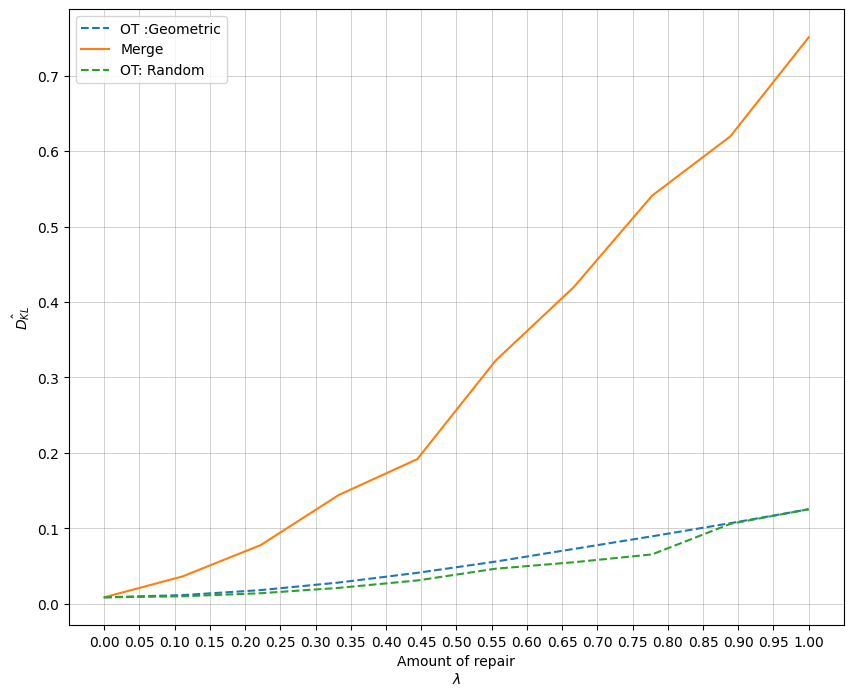

In [61]:
#plot the KLD _gmm
alpha_range = np.linspace(0,1,iter)

fig = plt.figure(figsize=(10, 8))
plt.plot(alpha_range, kld_gmm_geo, linestyle='dashed', label = 'OT :Geometric')
plt.plot(alpha_range, kld_gmm_merge,  label = 'Merge')
plt.plot(alpha_range, kld_gmm_random, linestyle='dashed', label = 'OT: Random')

plt.ylabel(r'$\hat{D_{KL}}$')
plt.xlabel('Amount of repair\n'+r'$\lambda$')
plt.legend()
# generate a sequence of 5 evenly spaced numbers between 0 and 4
grid_pos = np.arange(0, 1.05, 0.05)

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)
plt.show()


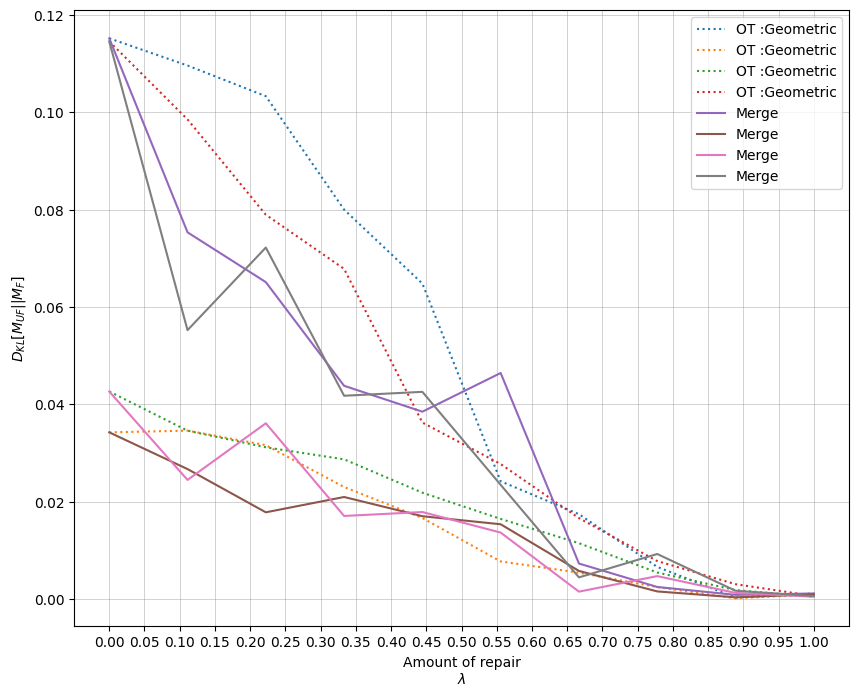

In [24]:

# #plot the klds list 
fig = plt.figure(figsize=(10, 8))
plt.plot(alpha_range,KLD_geo, linestyle='dotted',label = 'OT :Geometric')
plt.plot(alpha_range,KLD_merge,label = 'Merge')

plt.ylabel(r'$D_{KL}[M_{UF}||M_{F}]$')
plt.xlabel('Amount of repair\n'+r'$\lambda$')

plt.legend()
# generate a sequence of 5 evenly spaced numbers between 0 and 4
grid_pos = np.arange(0, 1.05, 0.05)

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)
plt.show()




In [25]:
KLD_list_geo = np.zeros(len(KLD_geo))
KLD_list_merge = np.zeros(len(KLD_merge))
KLD_list_random = np.zeros(len(KLD_random))

for i in range(len(KLD_list_geo)):
        KLD_list_geo[i] = np.sum(KLD_geo[i])
        KLD_list_merge[i] = np.sum(KLD_merge[i])
        KLD_list_random[i] = np.sum(KLD_random[i])

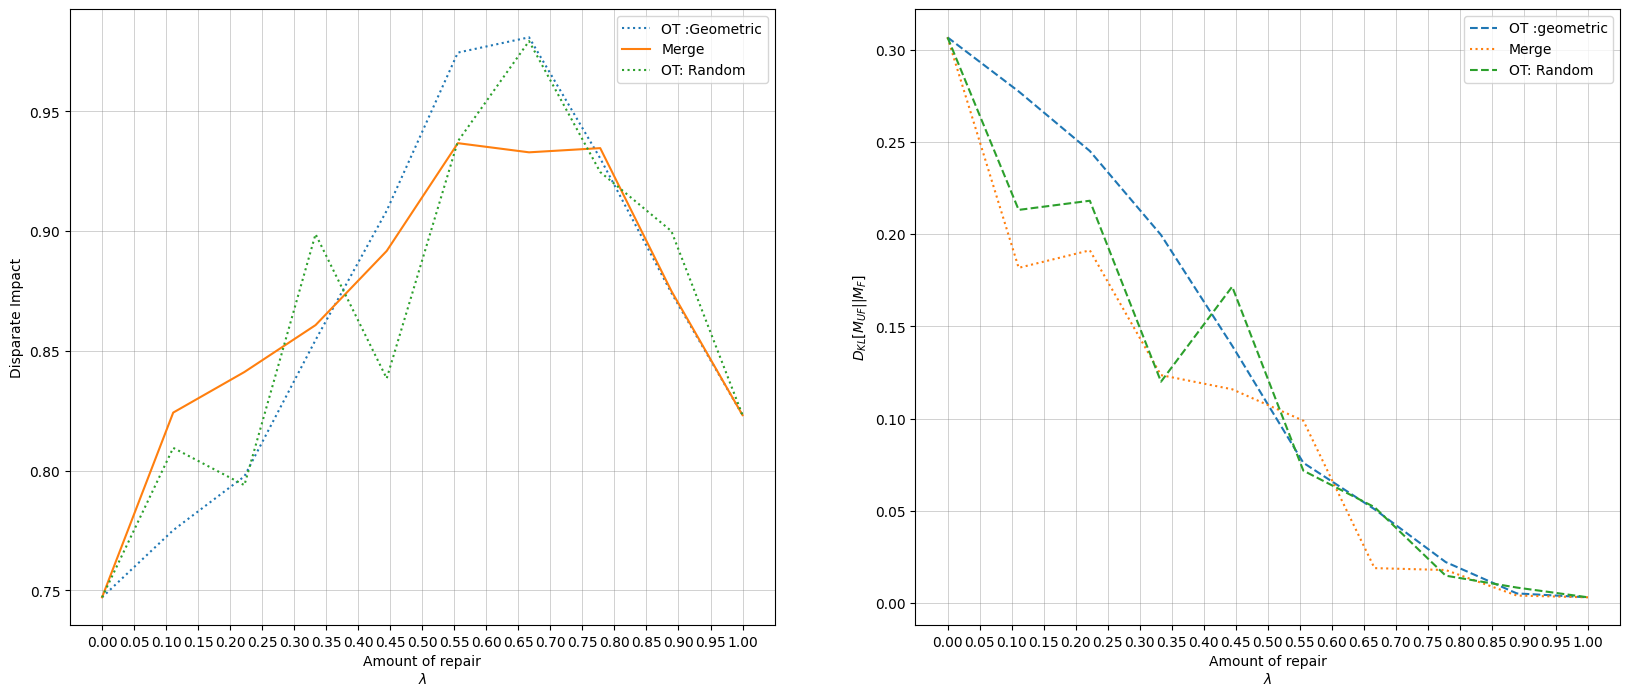

In [26]:

fig = plt.figure(figsize=(20 ,8))
plt.subplot(1, 2, 1)
plt.plot(alpha_range, DIs, linestyle='dotted', label = 'OT :Geometric')
plt.plot(alpha_range, DIs_2,  label = 'Merge')
plt.plot(alpha_range, DI_3, linestyle='dotted', label = 'OT: Random')

plt.ylabel('DI')
plt.xlabel('Amount of repair\n'+r'$\lambda$')
plt.ylabel('Disparate Impact')
plt.legend()
# generate a sequence of 5 evenly spaced numbers between 0 and 4
grid_pos = np.arange(0, 1.05, 0.05)

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)



# #plot the klds list 
plt.subplot(1, 2, 2)
plt.plot(alpha_range,KLD_list_geo, linestyle='dashed',  label = 'OT :geometric')
plt.plot(alpha_range,KLD_list_merge, linestyle='dotted', label = 'Merge')
plt.plot(alpha_range,KLD_list_random, linestyle='dashed', label = 'OT: Random')

plt.ylabel(r'$D_{KL}[M_{UF}||M_{F}]$')
plt.xlabel('Amount of repair\n'+r'$\lambda$')

plt.legend()
# generate a sequence of 5 evenly spaced numbers between 0 and 4
grid_pos = np.arange(0, 1.05, 0.05)

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)
plt.show()